In [1]:
import sys
sys.path.insert(0, '../..')
import allel; print('allel', allel.__version__)
import h5py
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import zarr
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')
import functools

allel 1.0.0.dev0


In [2]:
%%html
<style type="text/css">
.container {
    width: 98%;
    font-size: 25px;
    line-height: 1em;
}
.CodeMirror pre {
    line-height: 1.2em;
    font-size: 25px;
}
</style>

In [3]:
callset = zarr.group('/kwiat/2/coluzzi/ag1000g/data/phase1/release/AR3.1/variation/main/zarr2/ag1000g.phase1.ar3.pass/')
callset

Group(/, 6)
  arrays: 1; samples
  groups: 5; 2L, 2R, 3L, 3R, X
  store: DirectoryStore

In [4]:
genotypes = allel.GenotypeChunkedArray(callset['3R/calldata/genotype'])
genotypes

<GenotypeChunkedArray shape=(13167162, 765, 2) dtype=int8 chunks=(157284, 51, 2)
   nbytes=18.8G cbytes=1.1G cratio=17.7
   compression=blosc compression_opts={'cname': 'lz4', 'shuffle': 0, 'clevel': 5}
   values=zarr.core.Array>

In [5]:
accessibility = h5py.File('/kwiat/2/coluzzi/ag1000g/data/phase1/release/AR3/accessibility/accessibility.h5', mode='r')
accessibility

<HDF5 file "accessibility.h5" (mode r)>

In [6]:
@functools.lru_cache(maxsize=None)
def compute_roh(sample_index, chrom, phet_roh=0.001, phet_nonroh=(0.0025, 0.01)):
    genotypes = allel.GenotypeChunkedArray(callset[chrom]['calldata/genotype'])
    gv = genotypes[:, sample_index]
    is_accessible = accessibility[chrom]['is_accessible'][:]
    pos = callset[chrom]['variants/POS'][:]
    roh, froh = allel.roh_mhmm(gv, pos, phet_roh=0.001, phet_nonroh=(0.0025, 0.01), is_accessible=is_accessible)
    return roh, froh


In [44]:
def plot_roh(sample_index, chrom, phet_roh=0.001, phet_nonroh=(0.0025, 0.01), window_size=2000):

    genotypes = allel.GenotypeChunkedArray(callset[chrom]['calldata/genotype'])
    gv = genotypes[:, sample_index]

    # compute windowed heterozygosity
    is_het = gv.is_het()
    pos = callset[chrom]['variants/POS'][:]
    is_accessible = accessibility[chrom]['is_accessible'][:]
    windows = allel.equally_accessible_windows(is_accessible, window_size)
    wn, _, _ = allel.stats.windowed_statistic(pos, values=is_het, statistic=np.sum, windows=windows)

    # compute roh
    roh, froh = compute_roh(sample_index, chrom, phet_roh=phet_roh, phet_nonroh=phet_nonroh)
    
    # plotting setup
    fig, ax = plt.subplots(figsize=(40, 4))
    sns.despine(ax=ax, offset=10)

    # plot heterozygosity
    y = wn / window_size
    x = np.mean(windows, axis=1)
    ax.plot(x, y, linewidth=.5)
    ax.set_ylim(-0.01, 0.03)
    ax.set_yticks(np.arange(0, 0.03, 0.005))
    ax.set_xlim(0, is_accessible.size)
    ax.set_xlabel('position')
    ax.set_ylabel('heterozygosity')

    # plot roh
    xranges = [(start, stop-start) for (start, stop) in roh]
    yrange = (-.008, 0.006)
    ax.broken_barh(xranges, yrange, facecolor='gray', linewidth=.5, edgecolor='k')

    ax.text(1, 1, '$F_{ROH}$: %.4f\n$ROH$ count: %s' % (froh, len(roh)), transform=ax.transAxes, ha='right', va='top')
    
    # plot histogram of roh sizes
    x = roh[:, 1] - roh[:, 0]
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=np.logspace(2, 8, 30))
    ax.set_xscale('log')
    ax.set_xlabel('$ROH$ length')
    ax.set_ylabel('frequency')


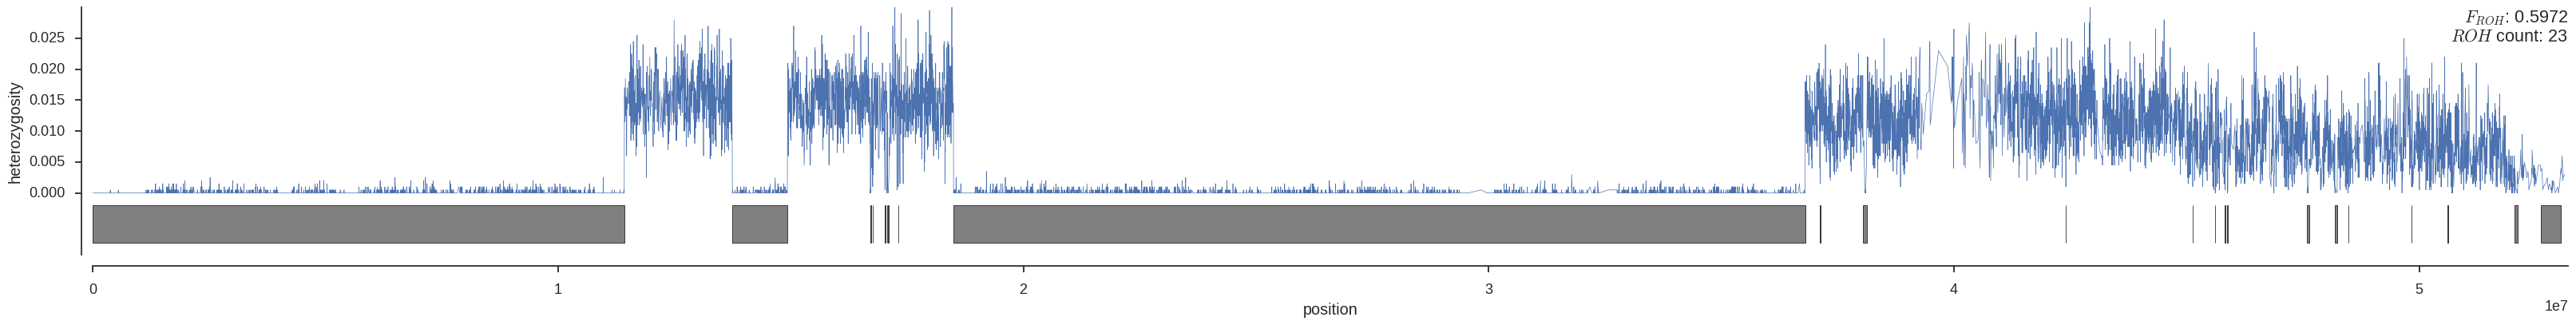

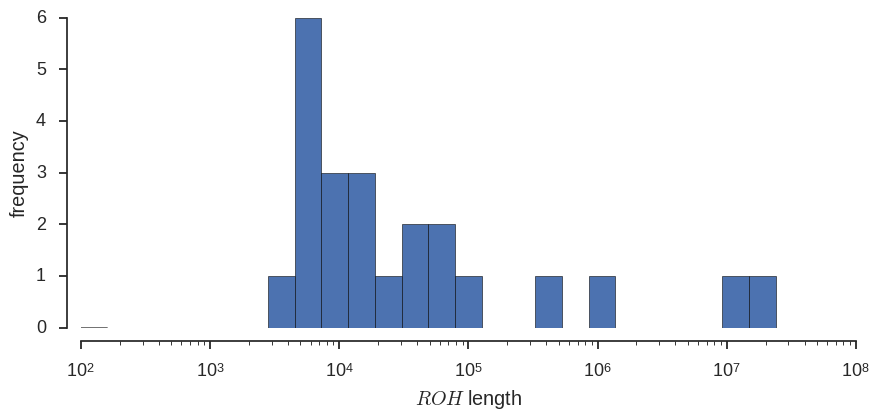

In [45]:
plot_roh(300, '3R')

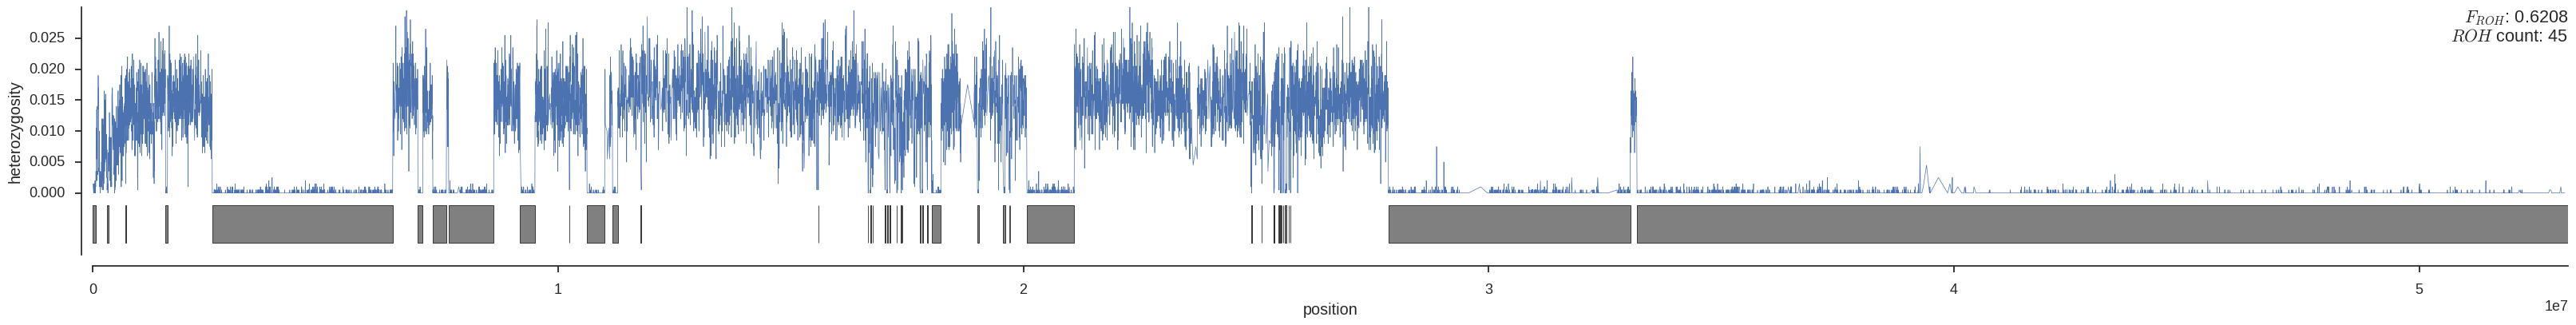

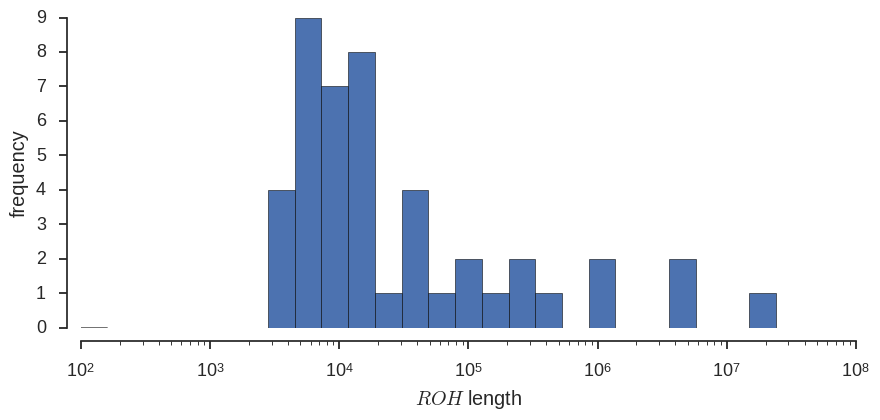

In [46]:
plot_roh(301, '3R')

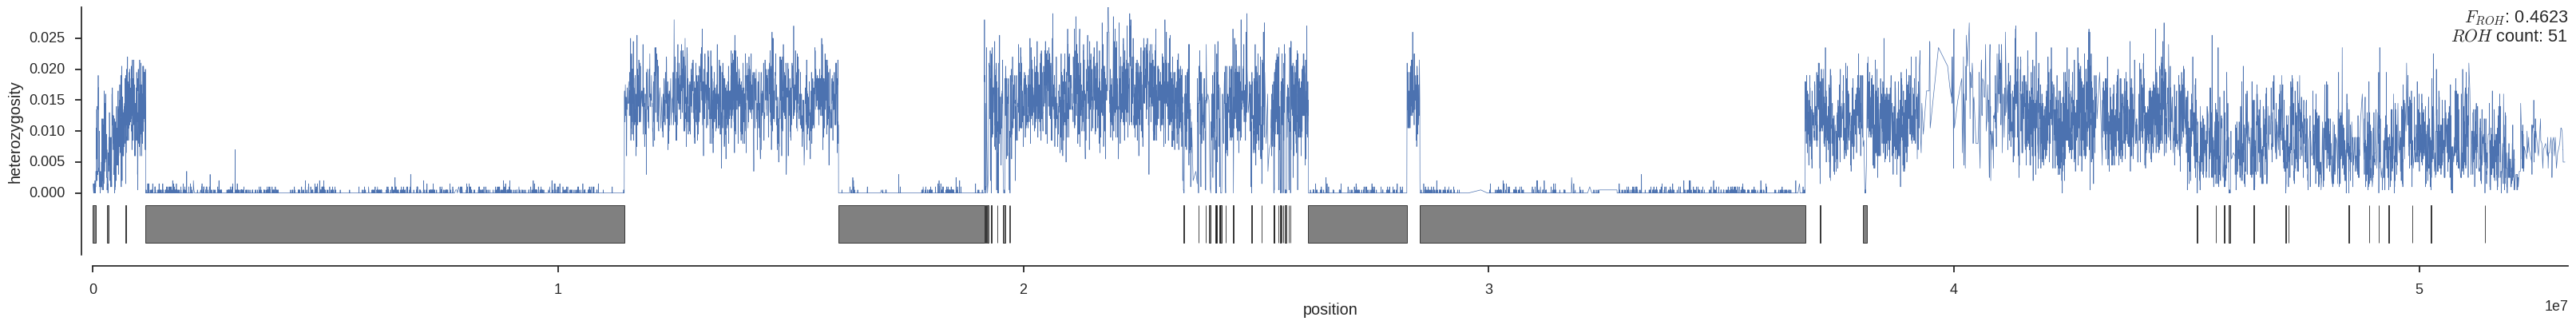

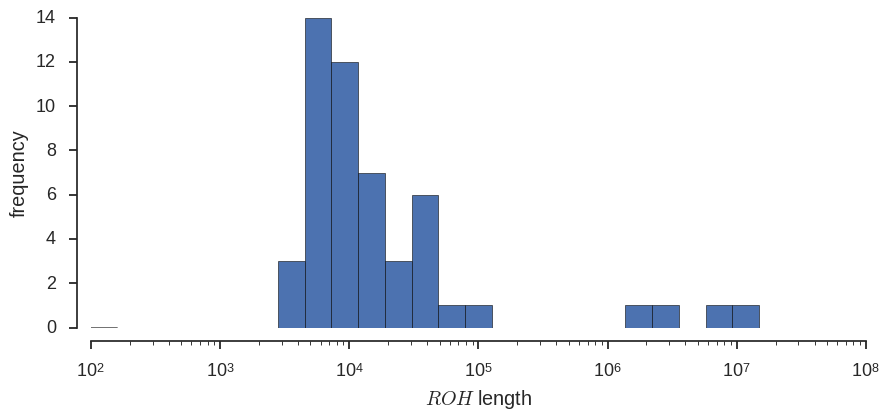

In [47]:
plot_roh(302, '3R')

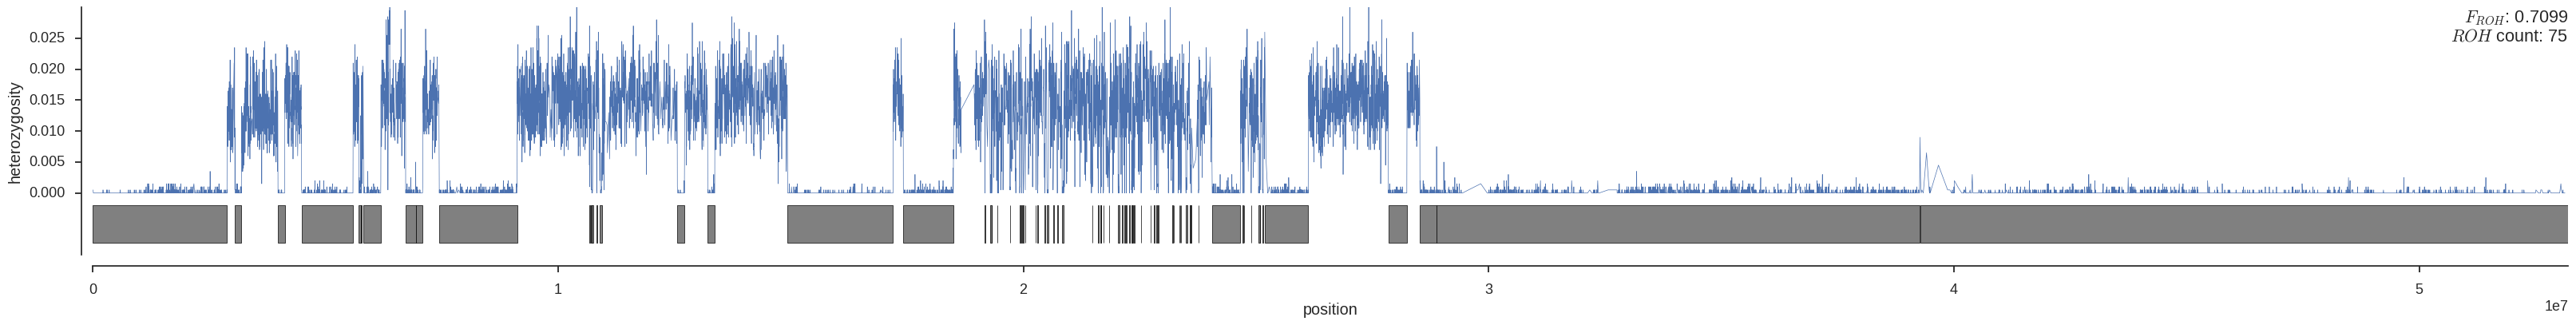

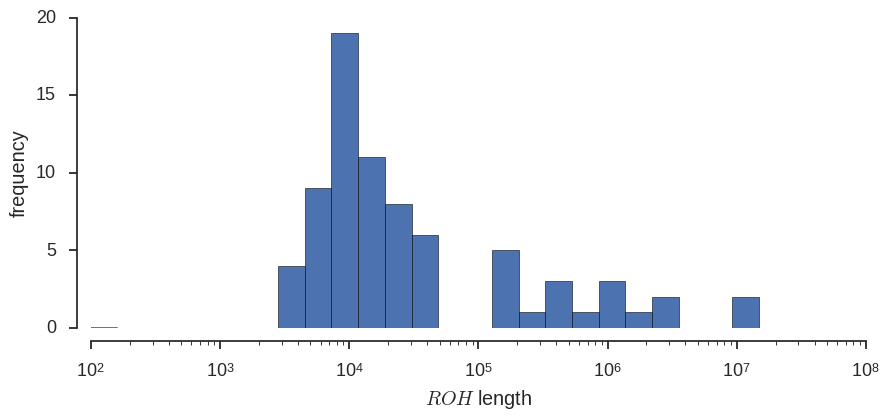

In [48]:
plot_roh(303, '3R')

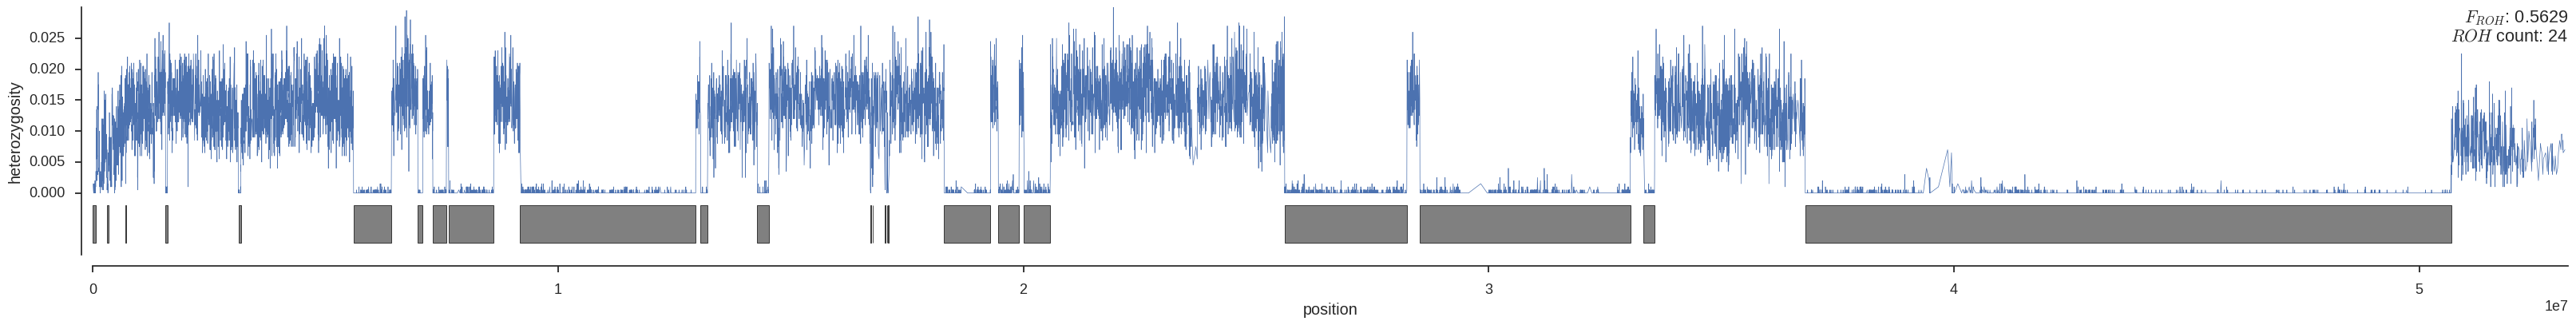

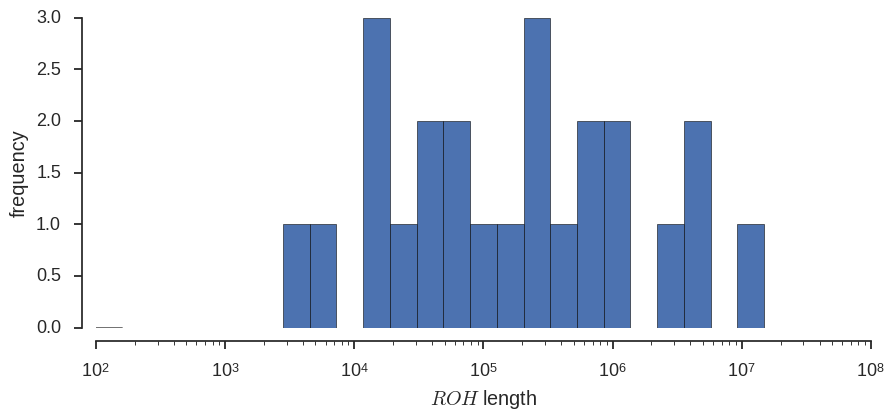

In [49]:
plot_roh(304, '3R')

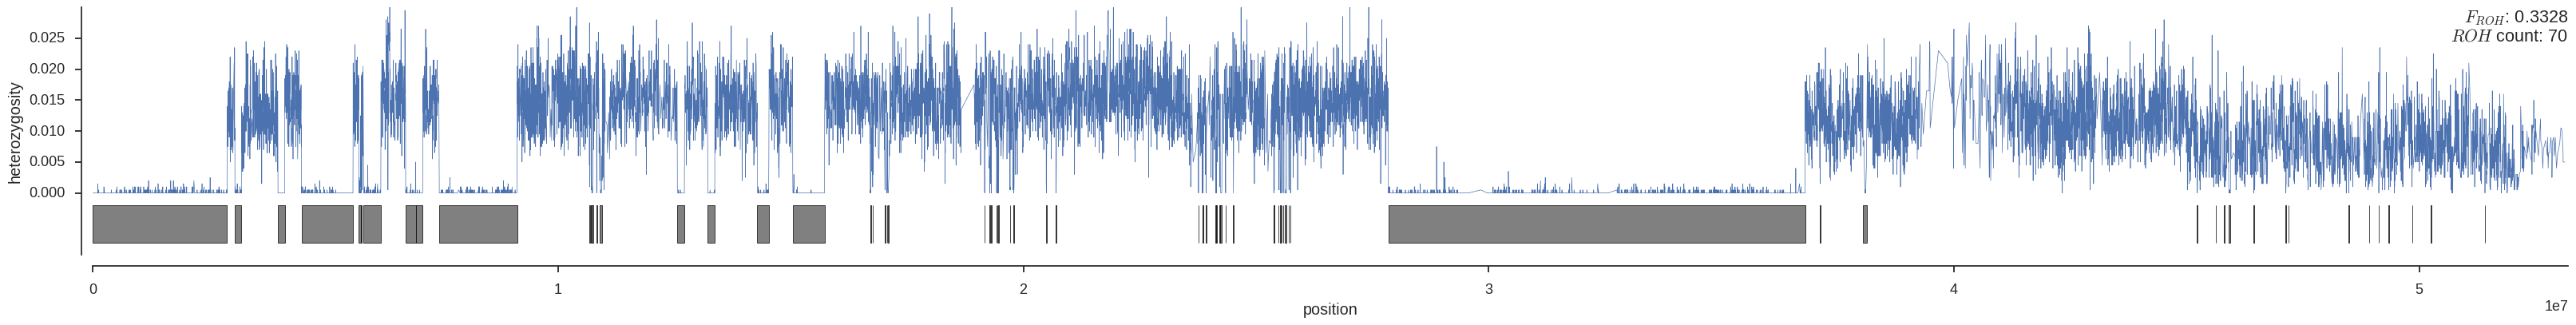

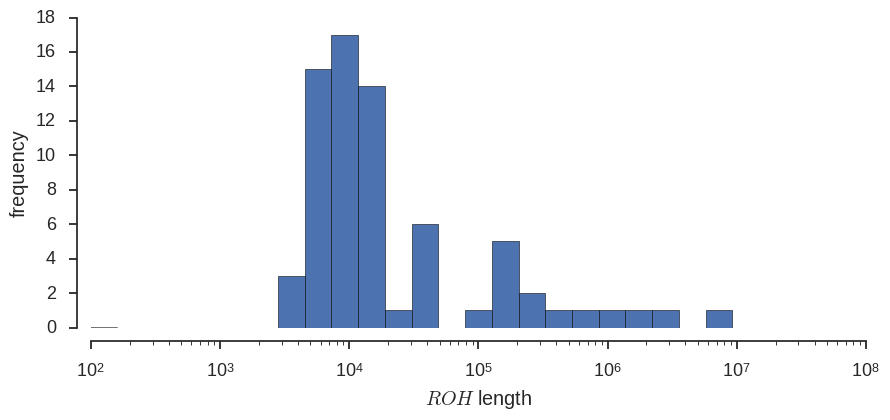

In [55]:
plot_roh(305, '3R')

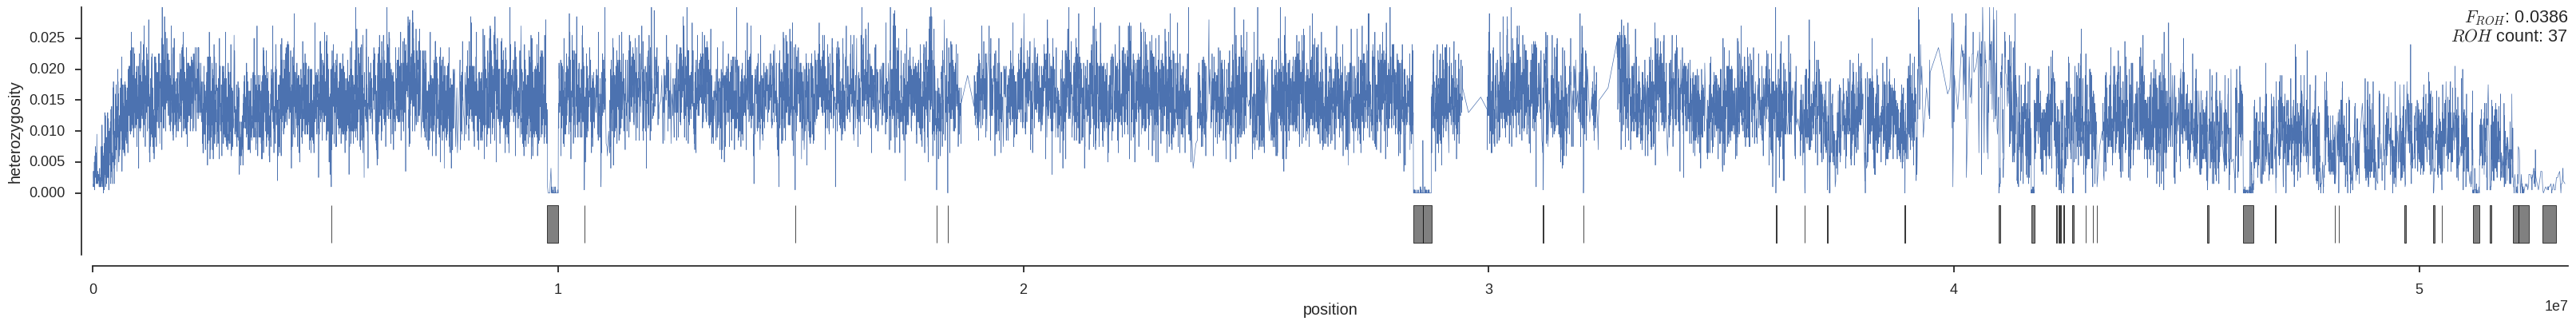

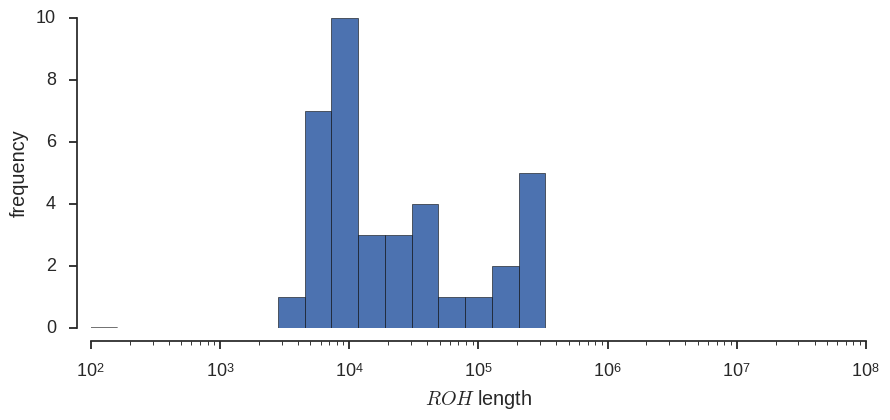

In [50]:
plot_roh(0, '3R')

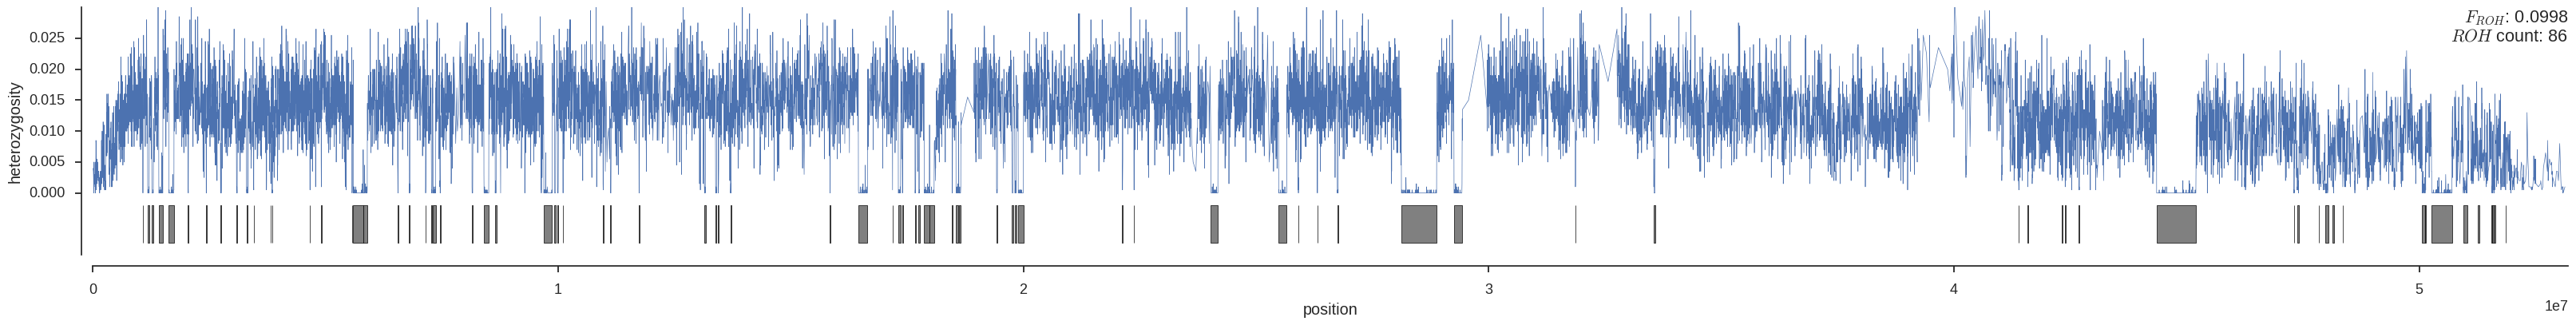

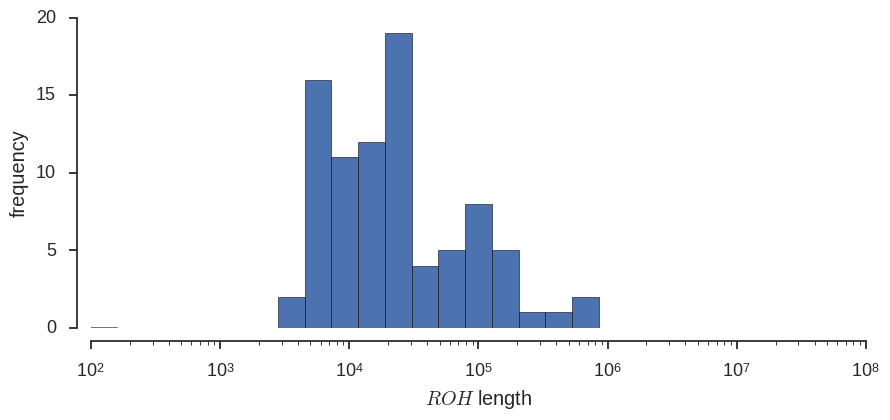

In [51]:
plot_roh(700, '3R')

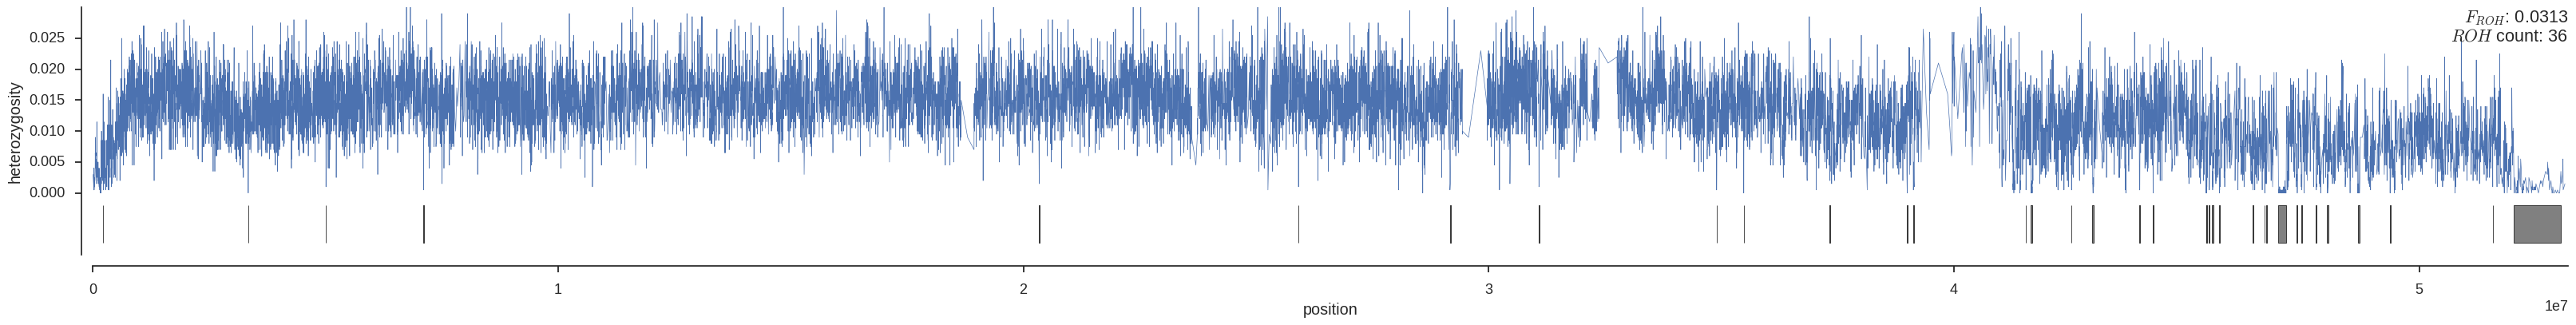

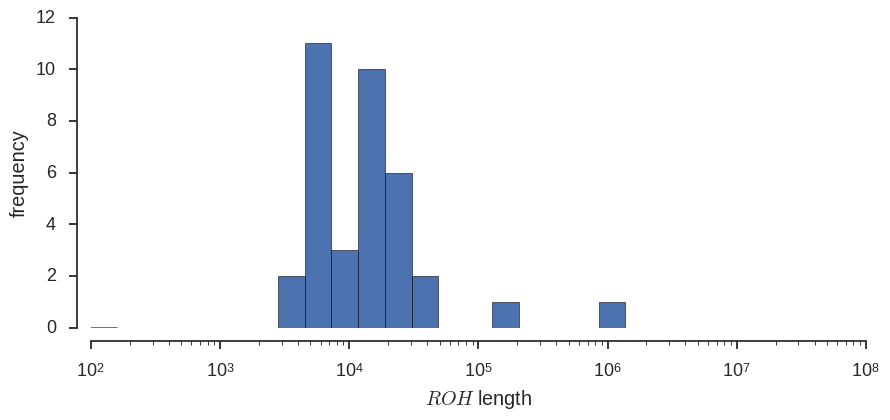

In [52]:
plot_roh(600, '3R')

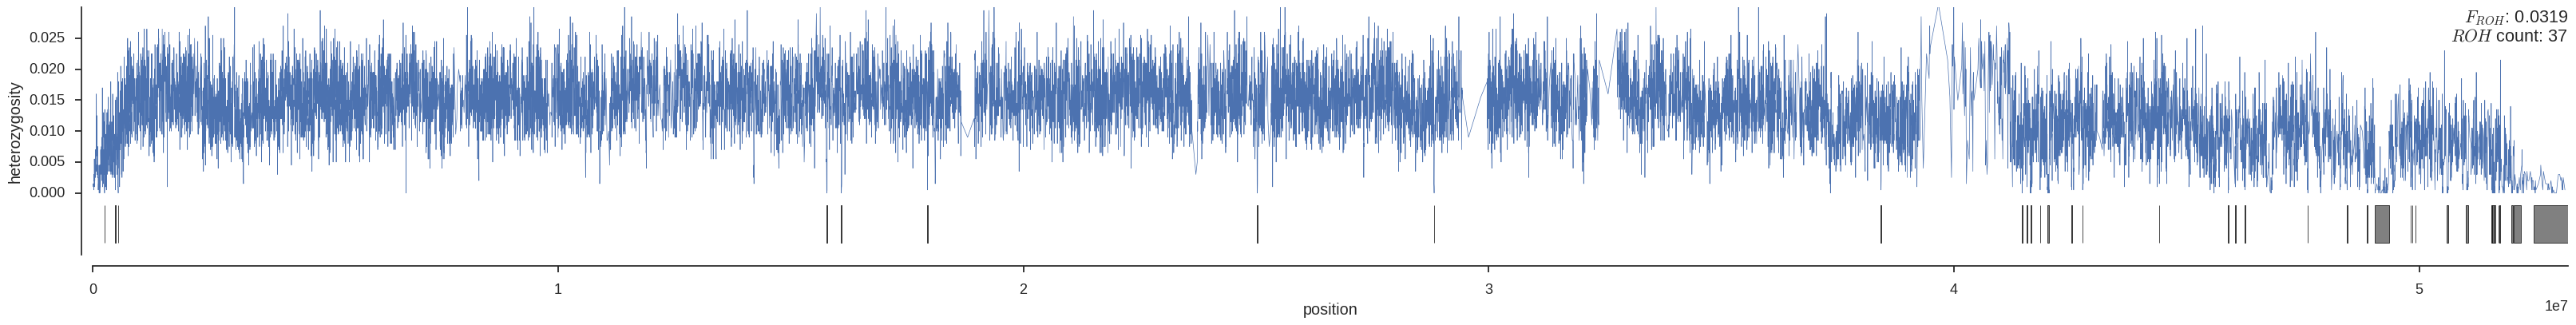

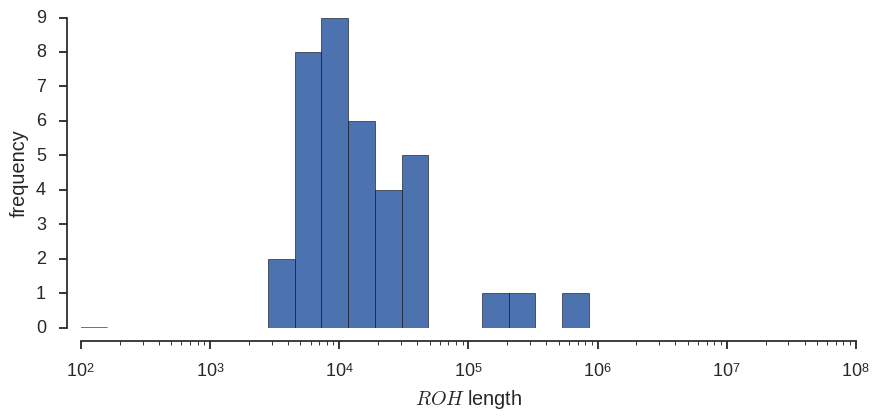

In [53]:
plot_roh(500, '3R')

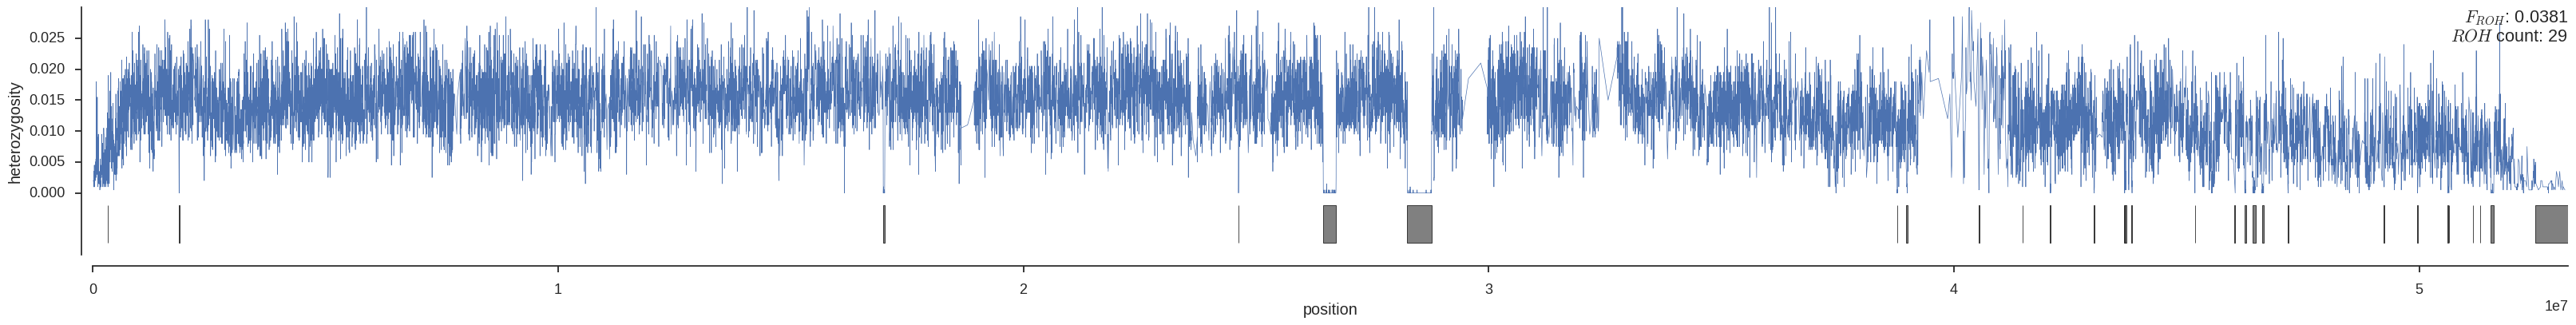

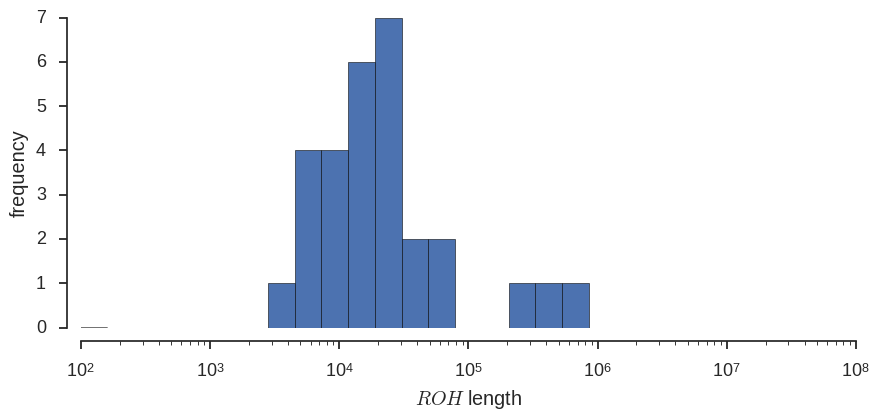

In [54]:
plot_roh(400, '3R')